## Imports

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa
import math
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset and EDA

In [ ]:
# Your custom base path
path_data = '/content/drive/MyDrive/Data/genres_original'
genre = 'pop'
filename = 'pop.00000.wav'

# Properly construct the full path
file_path = os.path.join(path_data, genre, filename)

print("Full path to file:", file_path)

Full path to file: /content/drive/MyDrive/Data/genres_original/pop/pop.00000.wav


In [ ]:
fs = 22050 # sampling rate for librosa to resample to
audio_ex, fs = librosa.load(path=file_path, sr=fs) # load audio and sampling rate

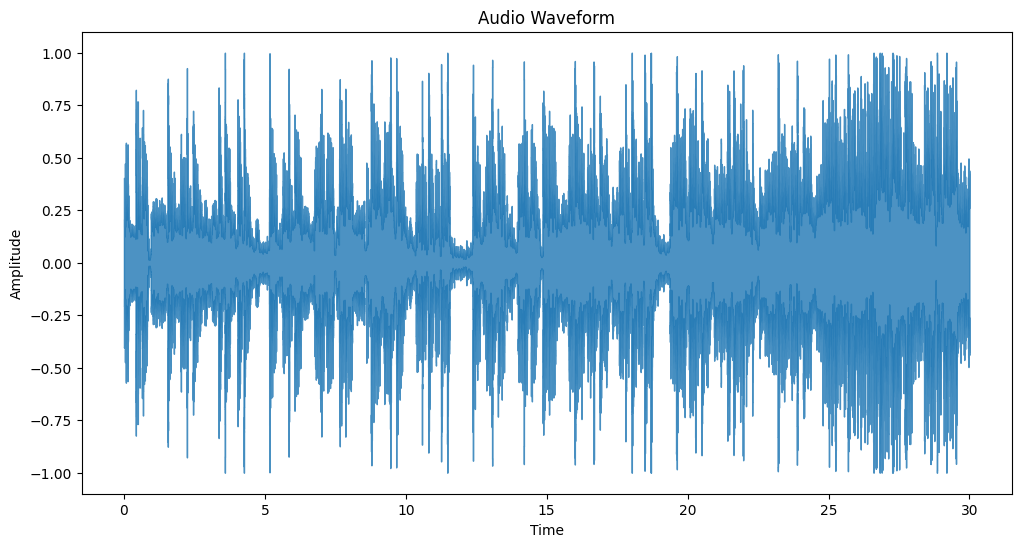

In [ ]:
def plot_waveform(audio, fs):
    """Plots the waveform of audio in the time domain.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal

    """
    plt.figure(figsize = (12, 6))
    librosa.display.waveshow(audio, sr=fs, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

# Create time axis
plot_waveform(audio_ex, fs);
plt.title('Audio Waveform');

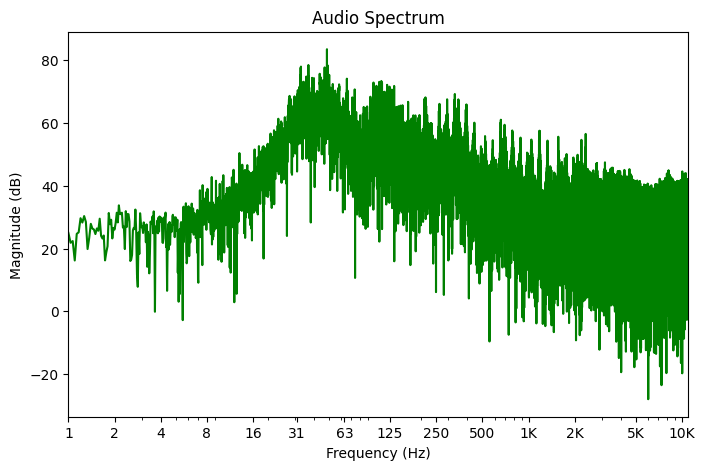

In [ ]:
import scipy

def calc_spec_db(audio, kind='mag'):
    """Calculates the spectrum of an audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    Returns:
        spec_db (numpy.ndarray) = the audio spectrum in db scale (re 20 μPa)
    """
    spec = scipy.fft.fft(x=audio)

    if kind.lower() == 'm' or 'mag' or 'magnitude':
        spec_db = 20*np.log10(np.abs(spec))
    elif kind.lower() == 'p' or 'pha' or 'phase':
        spec_db = 20*np.log10(np.imag(spec))
    elif kind.lower() == 'c' or 'com' or 'complex':
        spec_db = 20*np.log10(spec)

    return spec_db

def plot_spec(audio, fs, kind='mag'):
    """Plots the magnitude spectrum of an audio signal/

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        kind (str): type of spectrum to calculate
            - 'mag' = magnitude spectrum (real values)
            - 'phs' = phase spectrum (imaginary values)
            - 'com' = complex spectrum (both magnitude and phase)
    """
    # Calculate fft
    spec_db = calc_spec_db(audio, kind=kind)
    f_axis = np.linspace(0, fs, len(spec_db))#, endpoint=False) # create

    # Only take frequencies below nyquist frequency (i.e. fs/2)
    f_axis = f_axis[:int(len(spec_db)/2)]
    spec_db = spec_db[:int(len(spec_db)/2)]

    # Plot
    ax = plt.figure(figsize = (8, 5))
    plt.plot(f_axis, spec_db, color='green', alpha=1.0)
    plt.xscale('log')
    plt.xlim(1, fs/2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    if fs < 44100:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000],
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K"])
    else:
        plt.xticks([1, 2, 4, 8, 16, 31, 63, 125, 250,500,1000,2000,5000,10000, 20000],
                   ["1", "2", "4", "8", "16", "31", "63", "125", "250", "500", "1K", "2K", "5K", "10K", "20k"])

plot_spec(audio_ex, fs)
plt.title('Audio Spectrum');

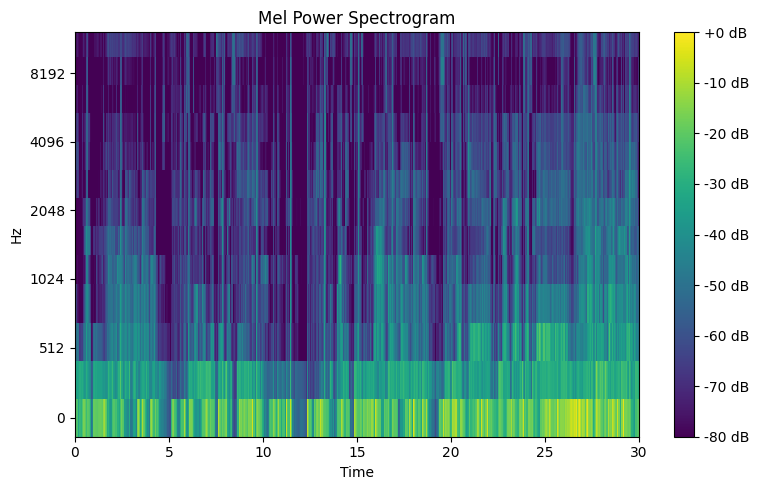

In [ ]:
def calc_mel_spec(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512):
    """calculates the Mel-scaled spectrogram.
    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
    Returns:
        mel_spec_db (numpy.ndarray): Mel-scaled spectrogram in dB
    """
    # Mel-scaled power spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=fs, n_mels=n_mfccs, n_fft=n_fft, hop_length=hop_length)

    # Convert to dB
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max) # ref - set max to 0 dB

    return mel_spec_db

def plot_mel_spectrogram_audio(audio, fs, n_mfccs=128, n_fft=2048, hop_length=512, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        fig_size (tuple): Dimensions of figure
    """
    # Calculate mel-spectrogram
    mel_spec_db = calc_mel_spec(audio, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length)

    # Plot spectogram
    plt.figure(figsize=fig_size)
    librosa.display.specshow(data=mel_spec_db, sr=fs, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title('Mel Power Spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

# Plot Mel-Spectrogram
n_mfccs = 13 # number of mel coeffs
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
plot_mel_spectrogram_audio(audio_ex, fs, n_mfccs=n_mfccs, n_fft=n_fft, hop_length=hop_length, fig_size=(8,5))

In [ ]:
# Load the audio files and convert them to MFCCs
# code modified from https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/12-%20Music%20genre%20classification%3A%20Preparing%20the%20dataset/code/extract_data.py
def get_mfccs(directory_path, fs=22500, duration=30, n_fft=2048, hop_length=512, n_mfcc=13, num_segments=10):
    """Reads through a directory of audio files and saves a dictionary of MFCCs and genres to a .json file. It also returns
    numpy.ndarrays for MFCCs, genre name, and genre number for each segment of audio signal.

    Parameters:
        audio (numpy.ndarray): audio signal
        fs (int): sampling frequency (Hz) of audio signal
        duration (int): duration of audio signal (sec)
        n_fft (int): The length (i.e. resolution) of the FFT window (must be power of 2)
        hop_length (int): The number of samples between successive frames
        n_mfccs: The number of MFCCs to compute (i.e. dimensionality of mel spectrum)
        num_segments (int): number of segments for the audio signal to be broken up into

    Returns:
        "mfcc" (numpy.ndarray): MFCC vectors for each segment
        "genre_name" (numpy.ndarray): name of the genre for each segment (i.e. blues, classical, etc.)
        "genre_num" (numpy.ndarray): number value of the genre for each segment (i.e. 0, 1, 2, etc.)
    """
    data = {
        "genre_name": [],   # name of the genre (i.e. blues, classical, etc.)
        "genre_num": [],    # number value of the genre (i.e. 0, 1, 2, etc.)
        "mfcc": []          # the mfcc vectors
    }

    # Calculate the number of samples per segment and the
    samples_per_track = fs * duration # Calculate the number of samples for desired "duration" of track
    samps_per_segment = int(samples_per_track/num_segments) # number of samples per segment
    mfccs_per_segment = math.ceil(samps_per_segment/hop_length) # number of MFCC vectors per segment

    # Loop through all folders & files in the data directory
        # path_current: Path to the current folder (start at outermost folder, then 'walk' in)
        # folder_names: List of names of all folders within the current folder
        # file_names: names List of names of all files within the current folder
        # i: index of current iteration
    print("MFCC collection started!")
    print("========================")
    for i, (path_current, folder_names, file_names) in enumerate(os.walk(directory_path)):

        # Check to make sure that the current folder is not the parent folder
        if path_current is not directory_path:

            # Save
            path_list = path_current.split('/') # split the path into a list
            genre_current = path_list[-1] # select last item in path list (name of folder = genre)

            # Loop through files for each genre (sub-directory)
            for file in file_names:

                # Load audio data
                file_path = os.path.join(path_current, file).replace(os.sep, '/') # create audio file path

                # try/except to skip a few files that create issues
                try:
                    # Load audio data and sampling frequency
                    audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate

                    # Loop through audio file for specified number of segments to calculate MFCCs
                    for seg in range(num_segments):

                        # Calculate the samples to bound each segment
                        start_sample = seg * samps_per_segment # segment starting sample
                        end_sample = start_sample + samps_per_segment # segment ending sample

                        # Calculate segment MFCC
                        mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample],    # audio signal
                                                    sr=fs,                               # sampling rate (Hz)
                                                    n_fft=n_fft,                         # fft window size
                                                    hop_length=hop_length,               # hop size
                                                    n_mfcc=n_mfcc)                       # number of mfccs to compute

                        mfcc = mfcc.T # transpose for appropriate list appending

                        # Confirm correct number of mfccs for each segment, then append
                        if len(mfcc) == mfccs_per_segment:
                            data["genre_name"].append(genre_current) # append current genre to list of genres
                            data["genre_num"].append(i-1) # append current genre to list of genres
                            data["mfcc"].append(mfcc.tolist()) # append current mfcc to list of mfccs
                except:
                    continue

            # Print update status
            print(f"Collected MFCCs for {genre_current.title()}!")

    with open('/content/drive/MyDrive/Data/data.json', "w") as filepath:
        print("========================")
        print("Saving data to disk...")
        json.dump(data, filepath, indent=4)
        print("Saving complete!")
        print("========================")

    # option to return MFCCs and genres
    return np.array(data["mfcc"]), np.array(data["genre_name"]), np.array(data["genre_num"])

In [ ]:
%%time
# Set up the parameters for the MFCC conversion
n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 10 # split teack into 10 segments (3 sec each)
track_duration = 30 # Length of tracks (sec)

directory_path = '/content/drive/MyDrive/Data/genres_original'
mfccs, genres, genre_nums = get_mfccs(directory_path,
                          fs=fs,
                          duration=track_duration,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mfcc=n_mfcc,
                          num_segments=num_segments)

MFCC collection started!
Collected MFCCs for Country!
Collected MFCCs for Classical!
Collected MFCCs for Rock!
Collected MFCCs for Pop!
Collected MFCCs for Disco!
Collected MFCCs for Metal!
Collected MFCCs for Reggae!
Collected MFCCs for Blues!
Collected MFCCs for Hiphop!


<ipython-input-11-3fc2410dd172>:57: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file_path, sr=fs) # audio in samples, sampling rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Collected MFCCs for Jazz!
Saving data to disk...
Saving complete!
CPU times: user 4min 26s, sys: 3.8 s, total: 4min 30s
Wall time: 3min 10s


## Modelling

In [ ]:
# Load in audio data
filepath = '/content/drive/MyDrive/Data/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

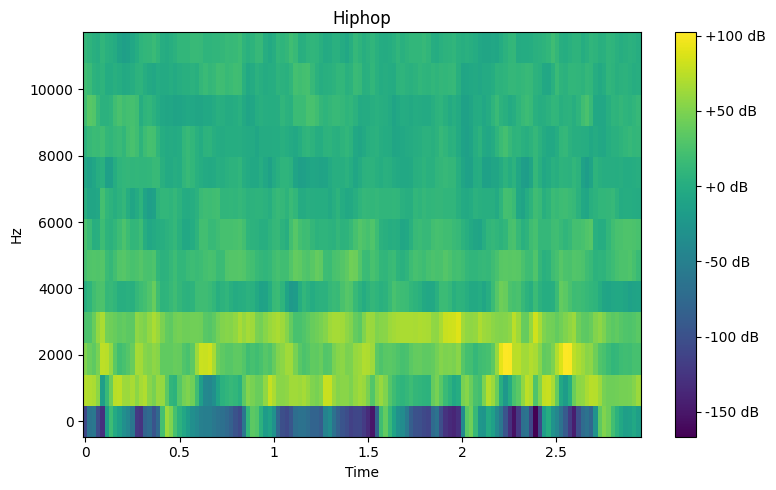

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(8,5)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.

    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')

    # Plot the MFFCs
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

# Plot MFCC example to ensure data was imported properly
idx = 8763
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

In [ ]:
# Review mfccs and genres for the correct shape
print(f"MFCCs: {np.array(data['mfcc']).shape}")
print(f"genres: {np.array(data['genre_name']).shape}")

MFCCs: (9971, 130, 13)
genres: (9971,)


Three types of models will be tested:

* Dense Neural Network (DNN)
* Convolutional Neural Network (CNN) (without regularization)
* Convolutional Neural Network (CNN) (with regularization)
* Recurrent Neural Network (RNN)

Additionally, data needs to be in the correct "shape" in order to input into certain models.
* DNN: (samples, features)
* CNN: (samples, height, width, channels)
* RNN: (samples, timesteps, features)

Data is also split into 3 sets
* Training set: For the model to train on
* Validation set: For the model to compare against while training
* Test set: A set unsees by the model until the end for final testing

### Data Preparation

In [ ]:
# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4885, 130, 13), y training data shape: (4885,)
X validation data shape: (2094, 130, 13), y validation data shape: (2094,)


In [ ]:
def plot_history(hist):
    """
    Plots the accuracy and loss for a model over all epochs.

    Parameters:
        hist (keras.callbacks.History): The History object returned by model.fit().
    """
    history = hist.history

    # Use 'accuracy' instead of 'acc' if available
    acc_key = 'accuracy' if 'accuracy' in history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))
    fig.tight_layout(pad=3)

    # Accuracy Plot
    axs[0].plot(history[acc_key], color='navy', label='Training Accuracy')
    axs[0].plot(history[val_acc_key], color='darkorange', label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)

    # Loss Plot
    axs[1].plot(history['loss'], color='navy', label='Training Loss')
    axs[1].plot(history['val_loss'], color='darkorange', label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    plt.show()

## Dense Neural Network (DNN)

* A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
* An 'l2' regularization penalty was leveraged to help mitigate overfitting.
* Dropout layers were included to help mitigate overfitting.
* Add batch normalization to speed up training and stabilize learning.

In [ ]:
# Model Definition
model_dnn = Sequential()

# Input Layer
model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

# Dense Block 1
model_dnn.add(Dense(512, kernel_regularizer=l2(0.0005)))
model_dnn.add(BatchNormalization())
model_dnn.add(Activation('relu'))
model_dnn.add(Dropout(0.4))

# Dense Block 2
model_dnn.add(Dense(256, kernel_regularizer=l2(0.0005)))
model_dnn.add(BatchNormalization())
model_dnn.add(Activation('relu'))
model_dnn.add(Dropout(0.4))

# Dense Block 3
model_dnn.add(Dense(64, kernel_regularizer=l2(0.0005)))
model_dnn.add(BatchNormalization())
model_dnn.add(Activation('relu'))
model_dnn.add(Dropout(0.3))

# Output Layer
model_dnn.add(Dense(10, activation='softmax'))

# Review model structure
model_dnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,546 (3.88 MB)

 Trainable params: 1,015,882 (3.88 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Compile
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
    )

In [ ]:
# Train the model
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.1662 - loss: 3.1787 - val_acc: 0.2875 - val_loss: 3.1553
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.2660 - loss: 2.7234 - val_acc: 0.3486 - val_loss: 2.4515
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.3206 - loss: 2.5126 - val_acc: 0.4117 - val_loss: 2.2433
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.3531 - loss: 2.4203 - val_acc: 0.4379 - val_loss: 2.1428
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.3786 - loss: 2.3574 - val_acc: 0.4733 - val_loss: 2.0861
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - acc: 0.4091 - loss: 2.2750 - val_acc: 0.4885 - val_loss: 2.0555
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - acc: 0.4278 - loss: 2.2240 - val_acc: 0.5100 - val_loss: 2.0136
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.4502 - loss: 2.1779 - val_acc: 0.5186 - val_loss: 1.9777
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - ac

In [ ]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5847 - loss: 2.0469
Test Loss: 2.149235248565674
Test Accuracy: 0.5705214142799377


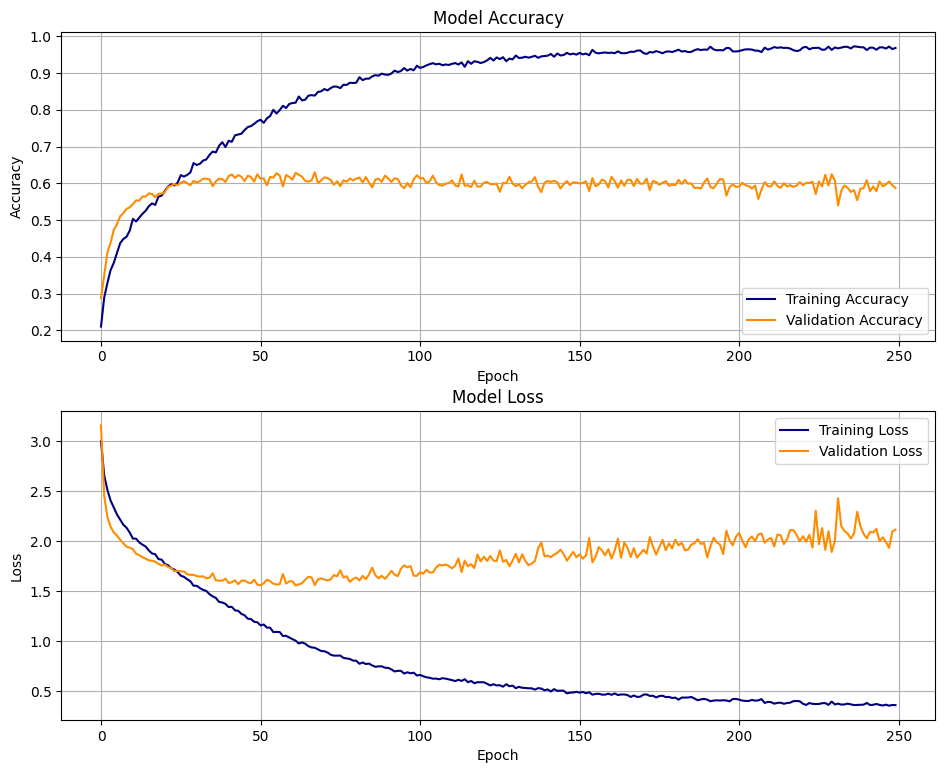

In [ ]:
plot_history(hist_dnn)

## Convolutional Neural Network (Without Regularization)
* A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
* Convolution layers first begin to identify features within the data, similar to edge detection in image data.
* The the data is flattened out to run through dense layers to classify the data.
* A base CNN was tested without regulatization methods to establish a base performance before iterating through tuning parameters.
* Data was augmented through normalization

In [ ]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape

(4885, 130, 13, 1)

In [ ]:
# Instantiate sequential model
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

model_cnn1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,418 (380.54 KB)

 Trainable params: 97,418 (380.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
%%time
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - acc: 0.1558 - loss: 4.6438 - val_acc: 0.3152 - val_loss: 2.1004
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - acc: 0.3327 - loss: 2.0230 - val_acc: 0.3758 - val_loss: 1.8199
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - acc: 0.3865 - loss: 1.7815 - val_acc: 0.4136 - val_loss: 1.6874
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - acc: 0.4238 - loss: 1.5958 - val_acc: 0.4432 - val_loss: 1.6202
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - acc: 0.4434 - loss: 1.5330 - val_acc: 0.4651 - val_loss: 1.5182
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - acc: 0.4737 - loss: 1.4608 - val_acc: 0.4623 - val_loss: 1.5042
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 0.4926 - loss: 1.3549 - val_acc: 0.4819 - val_loss: 1.4575
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - acc: 0.5327 - loss: 1.3138 - val_acc: 0.5014 - val_loss: 1.3831
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.6808 - loss: 2.0261
Test Loss: 2.154557943344116
Test Accuracy: 0.6701202988624573


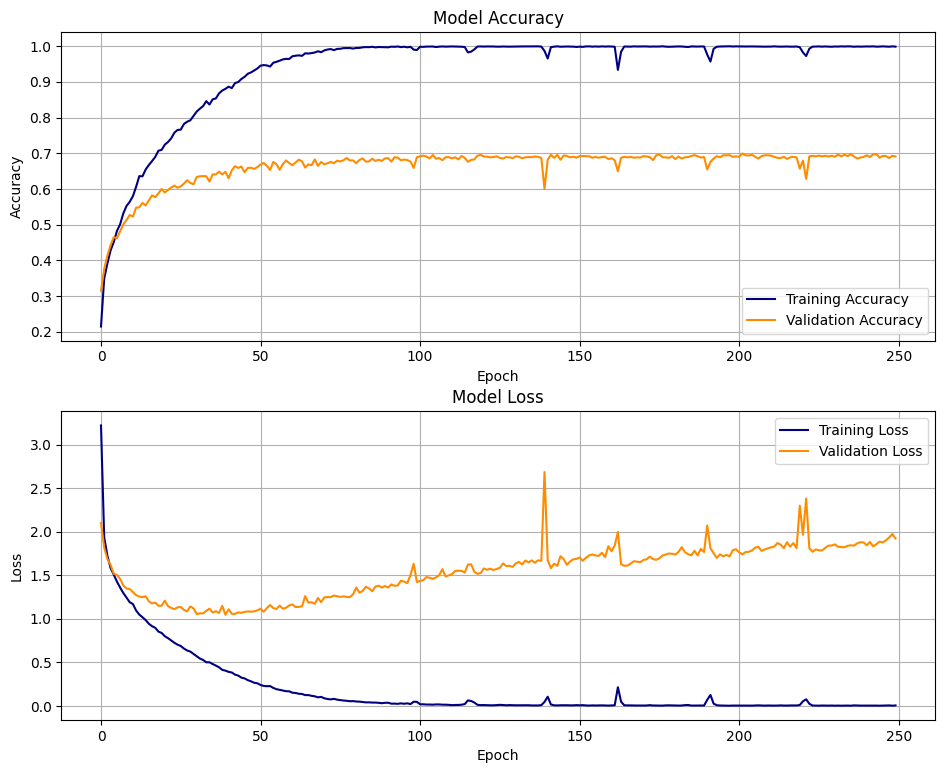

In [ ]:
plot_history(hist_cnn1)

## Convolutional Neural Network (With Regularization)
The CNN below went through many iterations to tune regularization parameters. We included:
* Dropout: Drops some nodes through each epoch to force all nodes to learn all features of the model. This helps reduce overfitting of the model.
* Early Stopping: This stops the model once it has reached a certain threshold of no longer improving. This also helps reduce overfitting.
* Regularization penalties (such as 'l2') were not leveraged for the CNN, as they do not improve the performance of the model.

In [ ]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape

(4885, 130, 13, 1)

In [ ]:
# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

model_cnn2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
#Compile
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# Create an early stopping callback
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0)

In [ ]:
%%time
# Train the model
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
    callbacks=[es_cnn2]
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - acc: 0.1333 - loss: 3.5010 - val_acc: 0.2259 - val_loss: 2.2467
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - acc: 0.2566 - loss: 2.5412 - val_acc: 0.3238 - val_loss: 1.8736
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - acc: 0.3114 - loss: 2.1811 - val_acc: 0.4140 - val_loss: 1.6669
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - acc: 0.3494 - loss: 1.9715 - val_acc: 0.4479 - val_loss: 1.6005
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - acc: 0.3860 - loss: 1.8156 - val_acc: 0.4637 - val_loss: 1.5613
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - acc: 0.4041 - loss: 1.6738 - val_acc: 0.4752 - val_loss: 1.5724
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - acc: 0.4370 - loss: 1.6393 - val_acc: 0.4866 - val_loss: 1.5049
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - acc: 0.4377 - loss: 1.6008 - val_acc: 0.5062 - val_loss: 1.4925
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7730 - loss: 0.7701
Test Loss: 0.7751694321632385
Test Accuracy: 0.7723930478096008


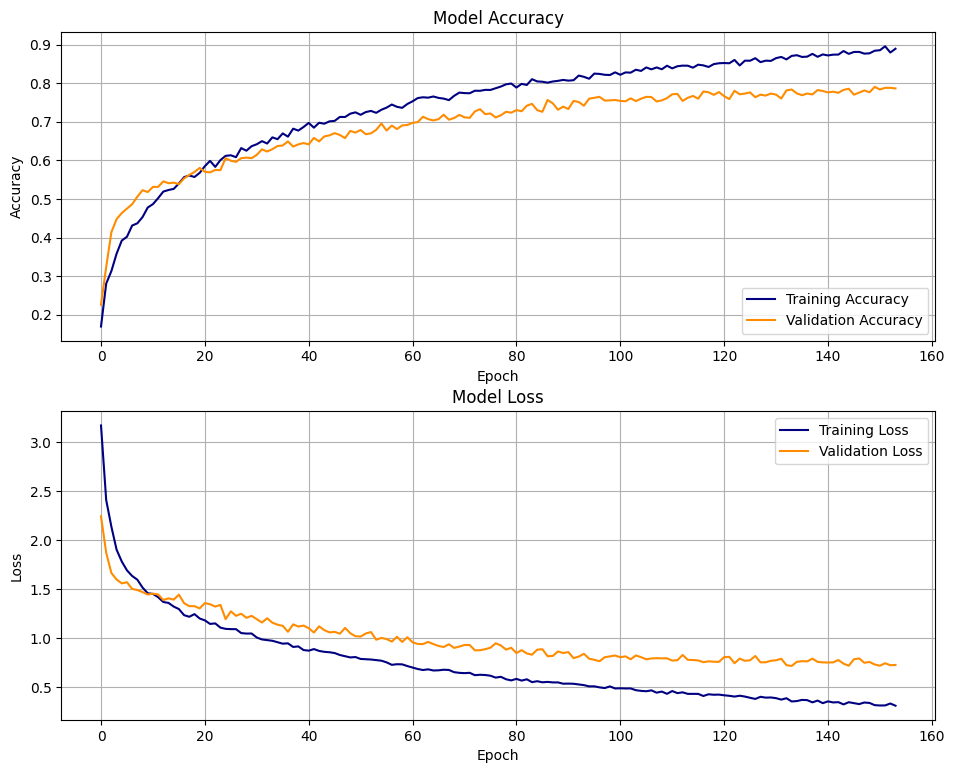

In [ ]:
plot_history(hist_cnn2)

## Recurring Neural Network

In [ ]:
# Add additional dimension for CNN
X_train_rnn = X_train
X_val_rnn = X_val
X_test_rnn = X_test

input_shape = X_train_rnn.shape[1:3]
X_train_rnn.shape

(4885, 130, 13)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Instantiate sequential model
model_rnn1 = Sequential()

# Add LSTM layers
model_rnn1.add(LSTM(64, return_sequences=True, input_shape=input_shape))  # First LSTM layer
model_rnn1.add(LSTM(64, return_sequences=False))  # Second LSTM layer

# Dense layers for classification
model_rnn1.add(Dense(64, activation='relu'))
model_rnn1.add(Dense(10, activation='softmax'))  # Output for 10 classes

model_rnn1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 64)        │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile RNN model
model_rnn1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
%%time
# Train the RNN model
hist_rnn1 = model_rnn1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1,
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - acc: 0.1148 - loss: 2.2896 - val_acc: 0.2378 - val_loss: 2.2029
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - acc: 0.2712 - loss: 2.1686 - val_acc: 0.3128 - val_loss: 2.0602
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - acc: 0.3430 - loss: 2.0095 - val_acc: 0.3677 - val_loss: 1.8703
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - acc: 0.3912 - loss: 1.8232 - val_acc: 0.4112 - val_loss: 1.7050
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - acc: 0.4371 - loss: 1.6530 - val_acc: 0.4255 - val_loss: 1.6073
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - acc: 0.4570 - loss: 1.5698 - val_acc: 0.4475 - val_loss: 1.5235
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - acc: 0.4734 - loss: 1.4913 - val_acc: 0.4632 - val_loss: 1.4782
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - acc: 0.4857 - loss: 1.4681 - val_acc: 0.4857 - val_loss: 1.4214
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
loss_rnn1, acc_rnn1 = model_rnn1.evaluate(X_test, y_test)
print(f"Test Loss: {loss_rnn1}")
print(f"Test Accuracy: {acc_rnn1}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - acc: 0.6221 - loss: 1.7721
Test Loss: 1.8567637205123901
Test Accuracy: 0.6092914342880249


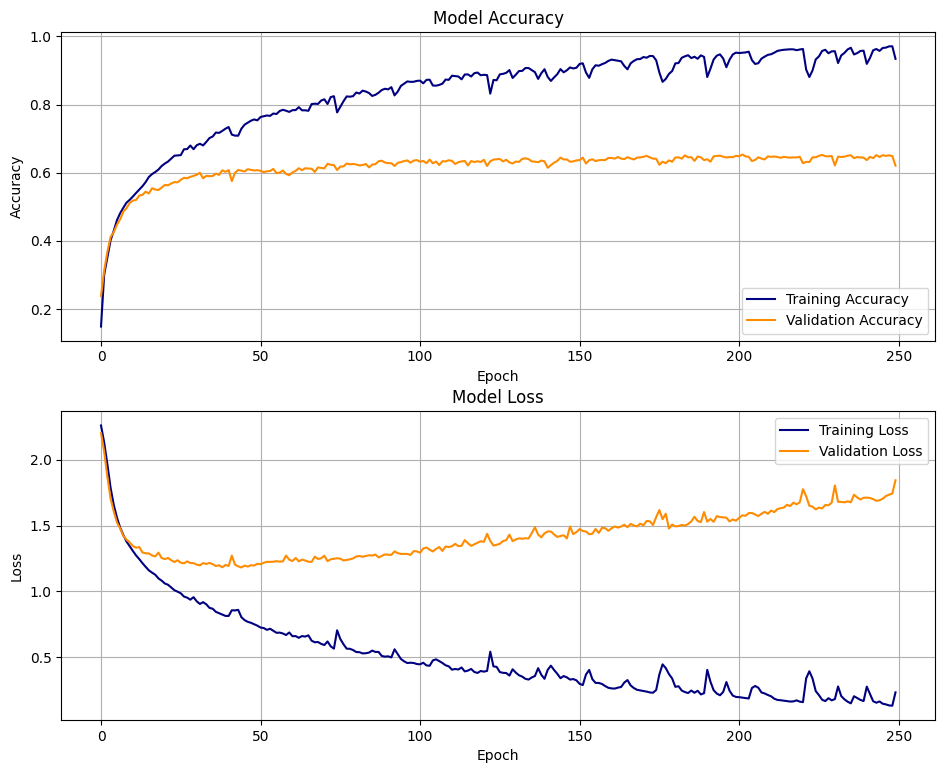

In [ ]:
plot_history(hist_rnn1)

## Store Models

In [ ]:
model_dnn.save('/content/drive/MyDrive/Data/models/model_dnn.h5')
model_cnn1.save('/content/drive/MyDrive/Data/models/model_cnn1.h5')
model_cnn2.save('/content/drive/MyDrive/Data/models/model_cnn2.h5')

## Prediction Model
Testing the models on the unseen i.e. the test data set.

In [ ]:
def make_prediction(model, X):
    """
    Makes predictions given a Keras model and a set of data.

    Parameters:
        model (keras.Model): Trained model for prediction.
        X (np.ndarray): Input data for prediction.

    Returns:
        preds_num (list): Predicted genre indices (0-9).
        preds_name (list): Predicted genre names (strings).
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
              'jazz', 'metal', 'pop', 'reggae', 'rock']

    # Predict all at once for efficiency
    predictions = model.predict(X)
    preds_num = np.argmax(predictions, axis=1)
    preds_name = [genres[i] for i in preds_num]

    return preds_num.tolist(), preds_name

In [ ]:
%%time
# Make predictions - Takes ~10 min to run
preds_num, preds_name = make_prediction(model_cnn2, X_test_cnn)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
CPU times: user 2.88 s, sys: 150 ms, total: 3.03 s
Wall time: 2.68 s


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

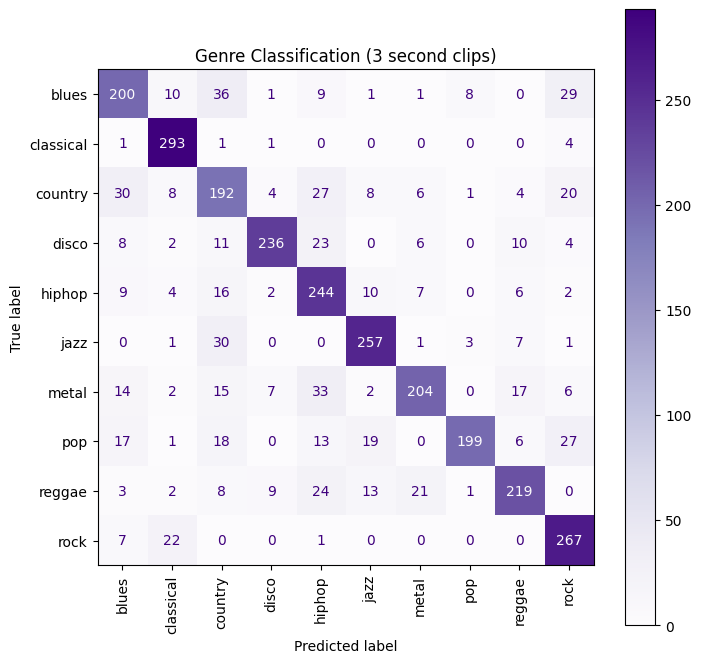

In [ ]:
# Plot confusion matrix for review
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');

## Summary of Results

Below are the final performance metrics for all models that were tested. Note that all models were ***overfit*** but it is not  uncommon with neural networks. Throughout the modelling process, I aimed to balance overfitting the model with performance to ensure optimal performance on unseen data.

|**Model**|**Accuracy**|
|---|---|
|**DNN**|0.570|
|**CNN (Without Regularization)**|0.670|
|**CNN (With Regularization)**|0.772|
|**RNN (With Regularization)**|0.609|